<a href="https://colab.research.google.com/github/alvincharles45/alvincharles45.github.io/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [2]:
!pip install xgboost shap -q

import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt


In [3]:
url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv"
df = pd.read_csv(url)
print("Initial shape:", df.shape)
df.head()


Initial shape: (20000, 21)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [4]:
def handle_age_at_sale(df, method='adjust'):
    """Compute 'age_at_sale' and fix invalid 'yr_built' vs 'sale_year' issues."""
    if method == 'nan':
        df['age_at_sale'] = df['sale_year'] - df['yr_built']
        df.loc[df['age_at_sale'] < 0, 'age_at_sale'] = np.nan
    elif method == 'zero':
        df['age_at_sale'] = df['sale_year'] - df['yr_built']
        df.loc[df['age_at_sale'] < 0, 'age_at_sale'] = 0
    elif method == 'adjust':
        df.loc[df['yr_built'] > df['sale_year'], 'yr_built'] = df['sale_year']
        df['age_at_sale'] = df['sale_year'] - df['yr_built']
    else:
        raise ValueError("method must be 'nan', 'zero', or 'adjust'")
    return df

# --- Parse date fields and create temporal features
df['date'] = pd.to_datetime(df['date'].str.replace('T000000', ''), errors='coerce')
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['sale_dayofweek'] = df['date'].dt.dayofweek

# --- Binary engineered columns
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df['high_grade'] = (df['grade'] > 10).astype(int)
df['low_grade'] = (df['grade'] < 7).astype(int)
df['sqft_living_x_grade'] = df['sqft_living'] * df['grade']
df['waterfront_x_sqft_living'] = df['sqft_living'] * df['waterfront']
df['has_basement'] = np.where(df['sqft_basement'] > 0, 1, 0)

df = handle_age_at_sale(df, method='adjust')
print("✅ Engineered features added.")


✅ Engineered features added.


In [5]:
# Example Census API pull (2015 ACS)
url = (
    "https://api.census.gov/data/2015/acs/acs5?"
    "get=NAME,B25001_001E,B25003_002E,B25003_003E,B11016_001E,"
    "B12001_001E,B12001_002E,B15003_001E,B15003_022E,B15003_023E,"
    "B15003_024E,B15003_025E,B23025_003E,B23025_005E"
    "&for=zip%20code%20tabulation%20area:*"
)
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_census = pd.DataFrame(data[1:], columns=data[0])
    df_census.rename(columns={'zip code tabulation area': 'zipcode'}, inplace=True)
    df_census['zipcode'] = df_census['zipcode'].astype(str).str.zfill(5)
    for col in df_census.columns:
        if col != 'zipcode' and col != 'NAME':
            df_census[col] = pd.to_numeric(df_census[col], errors='coerce')

    # Calculate key percentages
    df_census['percent_owner_occupied_2015'] = df_census['B25003_002E'] / df_census['B25001_001E'] * 100
    df_census['percent_renter_occupied_2015'] = df_census['B25003_003E'] / df_census['B25001_001E'] * 100
    df_census['unemployment_rate_2015'] = df_census['B23025_005E'] / (df_census['B23025_003E'] + df_census['B23025_005E']) * 100
    df_census['percent_hs_grad_or_higher_2015'] = (
        (df_census['B15003_022E'] + df_census['B15003_023E'] + df_census['B15003_024E'] + df_census['B15003_025E'])
        / df_census['B15003_001E'] * 100
    )
    df_census = df_census[['zipcode', 'percent_owner_occupied_2015', 'percent_renter_occupied_2015',
                           'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015']]

    # Merge into housing
    df['zipcode'] = df['zipcode'].astype(str).str.zfill(5)
    df = df.merge(df_census, on='zipcode', how='left')
    print("✅ Census data merged successfully.")
else:
    print("❌ Error fetching Census data:", response.status_code)


✅ Census data merged successfully.


In [6]:
cols_drop = ['id', 'price', 'date', 'yr_built', 'yr_renovated', 'sqft_above']
X = df.drop(columns=cols_drop)
y = df['price']

cat_features = ['zipcode', 'view', 'condition', 'grade', 'waterfront']
num_features = [col for col in X.select_dtypes(include=['int64','float64']).columns if col not in cat_features]

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Numerical Features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated', 'high_grade', 'low_grade', 'sqft_living_x_grade', 'waterfront_x_sqft_living', 'has_basement', 'age_at_sale', 'percent_owner_occupied_2015', 'percent_renter_occupied_2015', 'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015']
Categorical Features: ['zipcode', 'view', 'condition', 'grade', 'waterfront']
Train shape: (16000, 29), Test shape: (4000, 29)


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

xgb = XGBRegressor(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist"
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])


In [8]:
pipeline.fit(X_train, np.log1p(y_train))
y_pred = np.expm1(pipeline.predict(X_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test R²: {r2:.4f}")


Test RMSE: $131,778.10
Test R²: 0.8849


                            Feature  Importance
20   percent_hs_grad_or_higher_2015    0.255071
13              sqft_living_x_grade    0.096238
114                    waterfront_1    0.043181
95                           view_4    0.043007
14         waterfront_x_sqft_living    0.032571
113                    waterfront_0    0.032568
11                       high_grade    0.032090
91                           view_0    0.031518
33                    zipcode_98022    0.024107
6                               lat    0.019275
24                    zipcode_98004    0.018916
19           unemployment_rate_2015    0.014222
58                    zipcode_98074    0.013117
104                         grade_5    0.010161
2                       sqft_living    0.009354


  0%|          | 0/150 [00:00<?, ?it/s]

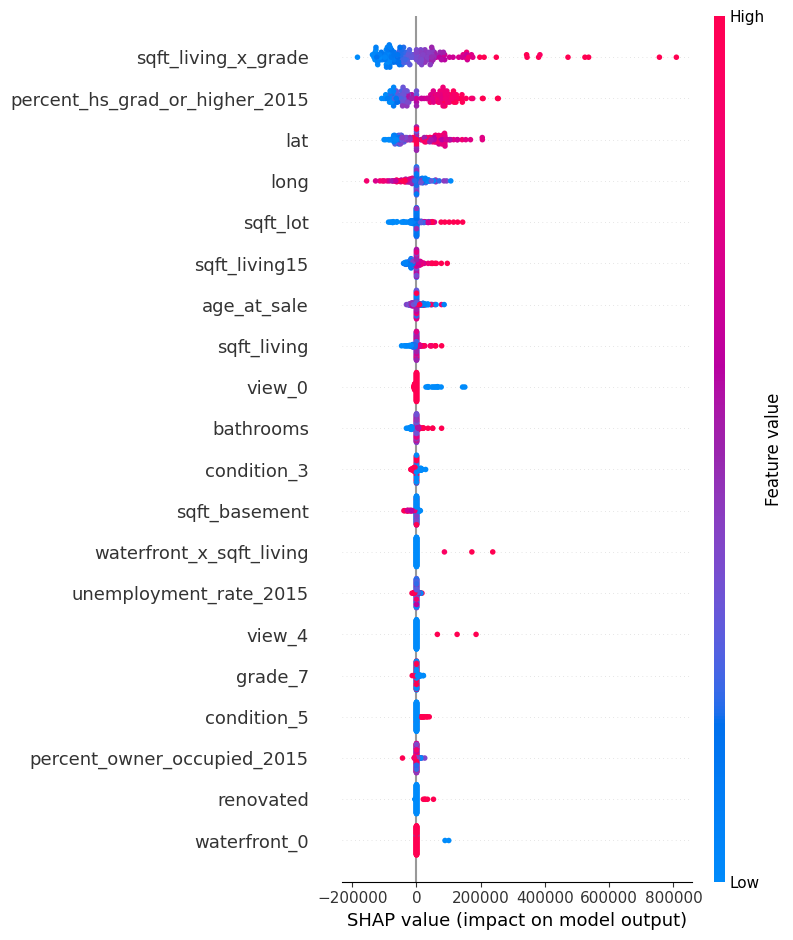

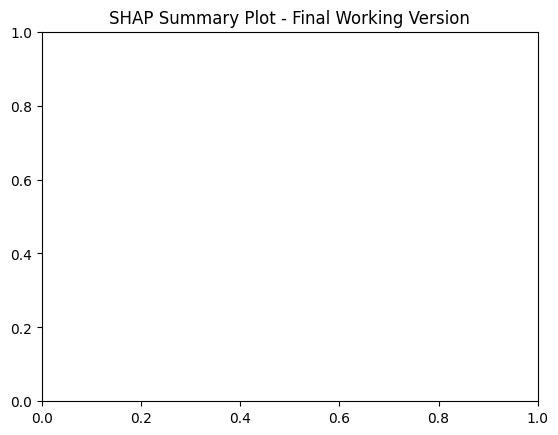

In [25]:
# === STEP 8 FINAL — Feature Importance + SHAP (working version) ===

xgb_raw = pipeline.named_steps['regressor']
preproc = pipeline.named_steps['preprocessor']

cat_out = preproc.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = list(num_features) + list(cat_out)

# Feature Importance table
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': xgb_raw.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(15))


# SHAP KERNEL EXPLAINER ON PREPROCESSED SPACE
import shap

# background sample
X_background = preproc.transform(X_train.sample(60, random_state=42))
X_background = np.array(X_background, dtype=float)

# transformed test
X_trans_test = preproc.transform(X_test)
X_trans_test = np.array(X_trans_test, dtype=float)

# prediction function DIRECTLY on processed numeric matrix:
def predict_fn(data):
    # data is numeric transformed data
    preds_log = xgb_raw.predict(data)       # model outputs LOG price
    return np.expm1(preds_log)              # convert back to price dollars

explainer = shap.KernelExplainer(predict_fn, X_background)

shap_values = explainer.shap_values(X_trans_test[:150])

shap.summary_plot(shap_values, X_trans_test[:150], feature_names=all_feature_names)
plt.title("SHAP Summary Plot - Final Working Version")
plt.show()
